In [1]:
import sys
sys.executable
import os

import findspark
findspark.init()

import pandas as pd
import pyspark

import pandas as pd
import numpy as np
#import pyspark.pandas as ps
from pyspark.sql import SparkSession
import matplotlib as plt
import seaborn as sns
from pyspark.sql.functions import col, sum



from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

LABEL_BASE_COL = None  
current = os.getcwd()
DATA_PATH = "heart_disease_uci.csv"  # <-- CAMBIA ESTA RUTA
DATA_PATH = os.path.join(current, DATA_PATH)
print(DATA_PATH)
CSV_SEP = ","                                 # separador común del CSV
OUTDIR = "outputs_corazon"

c:\Users\asrh_\anaconda3\envs\Bigdata_2025B\Bigdata\Challenges\heart_disease_uci.csv


In [2]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("challenge-3-avanzado-heart-v2")
    .getOrCreate()
)
spark

In [3]:
# ## 2. Carga de Datos
# Cargamos el archivo CSV con los datos del vino y revisamos las primeras filas.

# Cargar el archivo CSV

from pyspark.sql import functions as F
import os

os.makedirs(OUTDIR, exist_ok=True)

raw = spark.read.csv(DATA_PATH, header=True, inferSchema=True, sep=CSV_SEP)
raw.printSchema()
raw.show(5)

root
 |-- id: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: boolean (nullable = true)
 |-- restecg: string (nullable = true)
 |-- thalch: integer (nullable = true)
 |-- exang: boolean (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: string (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: string (nullable = true)
 |-- num: integer (nullable = true)

+---+---+------+---------+---------------+--------+----+-----+--------------+------+-----+-------+-----------+---+-----------------+---+
| id|age|   sex|  dataset|             cp|trestbps|chol|  fbs|       restecg|thalch|exang|oldpeak|      slope| ca|             thal|num|
+---+---+------+---------+---------------+--------+----+-----+--------------+------+-----+-------+-----------+---+--------------

In [4]:
# Detección de la columna objetivo y creación de `label` binaria

# Detectar columna objetivo si no se especificó
candidates = [c for c in raw.columns if c.lower() in ("target", "num")]
base_col = LABEL_BASE_COL if LABEL_BASE_COL else (candidates[0] if candidates else None)

if base_col is None:
    raise ValueError("No se pudo detectar la columna objetivo automáticamente. "
                     "Indica LABEL_BASE_COL con el nombre correcto (p. ej., 'target' o 'num').")

print("Columna base para etiqueta:", base_col)

# Mapeo a binaria: label = 1 si valor > 0, 0 en otro caso
df = raw.withColumn("label", (F.col(base_col).cast("double") > F.lit(0.0)).cast("int"))
df.select(base_col, "label").groupBy("label").count().orderBy("label").show()

Columna base para etiqueta: num
+-----+-----+
|label|count|
+-----+-----+
|    0|  411|
|    1|  509|
+-----+-----+



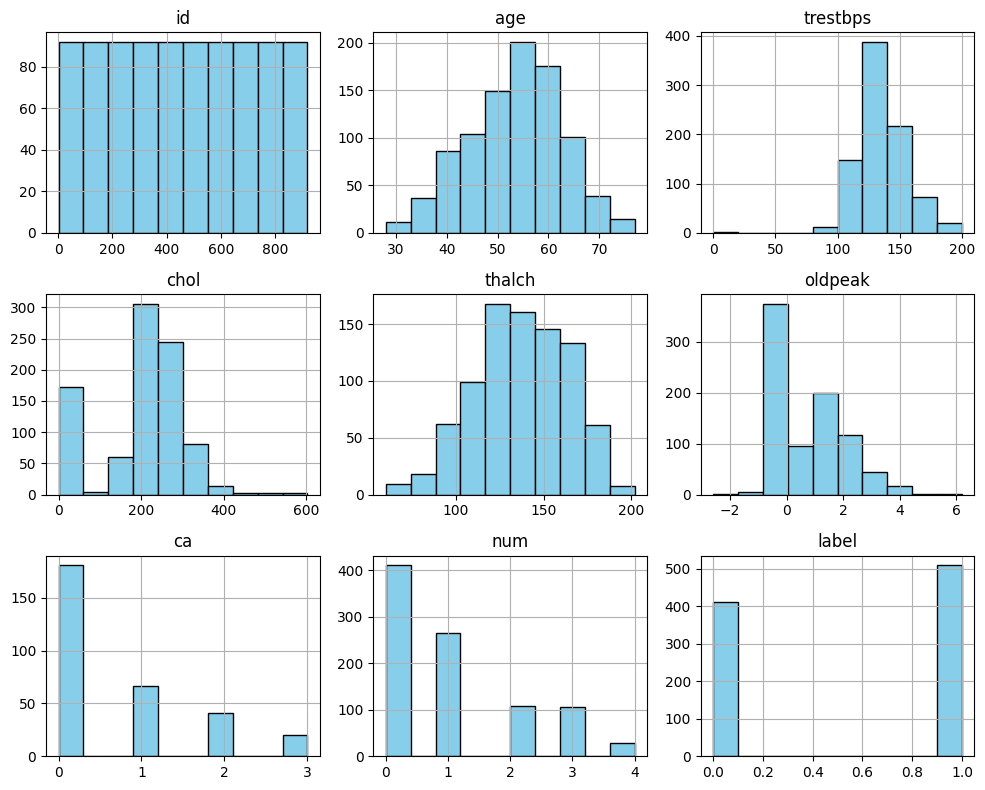

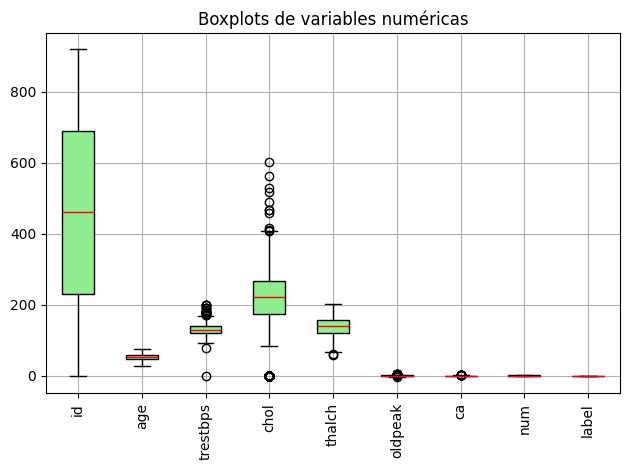

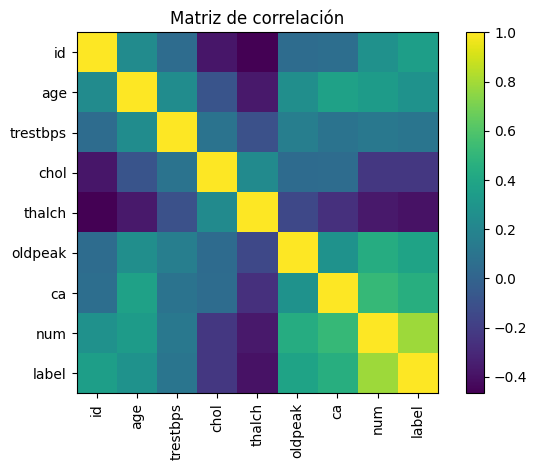

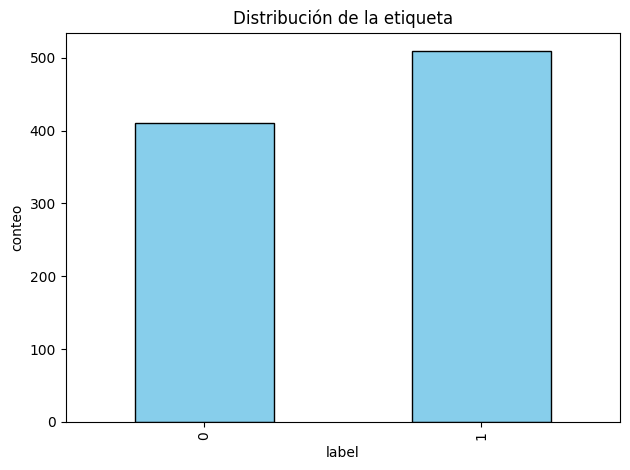

In [5]:
# EDA con gráficas

import matplotlib.pyplot as plt

# Seleccionar solo columnas numéricas para las gráficas
numeric_cols = [c for (c, t) in df.dtypes if t in ("int", "bigint", "double", "float")]
pdf = df.select(numeric_cols).toPandas()

# 5.1 Histogramas
ax = pdf.hist(figsize=(10, 8), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "histogramas.png"))
plt.show()

# 5.2 Boxplots
plt.figure()
pdf.boxplot(rot=90, patch_artist=True,
            boxprops=dict(facecolor='lightgreen'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'))
plt.title("Boxplots de variables numéricas")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "boxplots.png"))
plt.show()

# 5.3 Matriz de correlación
plt.figure()
corr = pdf.corr(numeric_only=True)
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.colorbar()
plt.title("Matriz de correlación")
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, "correlacion.png"))
plt.show()

# 5.4 Distribución de la etiqueta
if "label" in df.columns:
    label_pdf = df.select("label").toPandas()
    plt.figure()
    label_pdf["label"].value_counts().sort_index().plot(
        kind='bar',
        color='skyblue',
        edgecolor='black'
    )

    plt.title("Distribución de la etiqueta")
    plt.xlabel("label")
    plt.ylabel("conteo")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTDIR, "distribucion_label.png"))
    plt.show()

In [6]:
df = raw.toPandas()
spark_df = spark.createDataFrame(df)


In [7]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [8]:
spark_df.head()

Row(id=1, age=63, sex='Male', dataset='Cleveland', cp='typical angina', trestbps=145.0, chol=233.0, fbs=True, restecg='lv hypertrophy', thalch=150.0, exang=False, oldpeak=2.3, slope='downsloping', ca=0.0, thal='fixed defect', num=0)

In [9]:
# 3. Preprocesamiento: Imputar valores nulos

from pyspark.sql.functions import when, isnan, col, lit

for c in ["trestbps", "chol", "thalch", "oldpeak"]:
    spark_df = spark_df.withColumn(
        c,
        when(isnan(col(c)), lit(None)).otherwise(col(c))
    )

mean_trestbps = spark_df.select("trestbps").agg({"trestbps": "mean"}).first()[0]
mean_chol = spark_df.select("chol").agg({"chol": "mean"}).first()[0]
mean_thalch = spark_df.select("thalch").agg({"thalch": "mean"}).first()[0]
mean_oldpeak = spark_df.select("oldpeak").agg({"oldpeak": "mean"}).first()[0]
print(mean_trestbps)
print(mean_chol)
print(mean_thalch)
print(mean_oldpeak)

# Ahora sí se aplica el fill para los null convertidos
# Calcular las medias para las columnas con valores nulos y rellenarlos
# Aplicar imputación
spark_df = spark_df.na.fill({
    "trestbps": mean_trestbps,
    "chol": mean_chol,
    "thalch": mean_thalch,
    "oldpeak": mean_oldpeak
})

132.13240418118468
199.13033707865168
137.5456647398844
0.8787878787878788


In [10]:
from pyspark.sql.functions import col, isnan, when, count

# 1. Verificar cuántos valores null hay en cada columna
spark_df.select([
    count(when(col(c).isNull(), c)).alias(f"{c}_nulls") for c in ["trestbps","chol","thalch","oldpeak"]
]).show()

# 2. Verificar cuántos valores NaN hay (solo para columnas numéricas)
spark_df.select([
    count(when(isnan(col(c)), c)).alias(f"{c}_nans") for c in ["trestbps","chol","thalch","oldpeak"]
]).show()

+--------------+----------+------------+-------------+
|trestbps_nulls|chol_nulls|thalch_nulls|oldpeak_nulls|
+--------------+----------+------------+-------------+
|             0|         0|           0|            0|
+--------------+----------+------------+-------------+

+-------------+---------+-----------+------------+
|trestbps_nans|chol_nans|thalch_nans|oldpeak_nans|
+-------------+---------+-----------+------------+
|            0|        0|          0|           0|
+-------------+---------+-----------+------------+



In [11]:
"""spark_df = spark_df.na.fill({
    "trestbps": mean_trestbps,
    "chol": mean_chol,
    "thalch": mean_thalch,
    "oldpeak": mean_oldpeak
})"""
print(type(spark_df))
spark_df.show(50, truncate=False)

<class 'pyspark.sql.dataframe.DataFrame'>
+---+---+------+---------+---------------+--------+-----+-----+--------------+------+-----+-------+-----------+---+-----------------+---+
|id |age|sex   |dataset  |cp             |trestbps|chol |fbs  |restecg       |thalch|exang|oldpeak|slope      |ca |thal             |num|
+---+---+------+---------+---------------+--------+-----+-----+--------------+------+-----+-------+-----------+---+-----------------+---+
|1  |63 |Male  |Cleveland|typical angina |145.0   |233.0|true |lv hypertrophy|150.0 |false|2.3    |downsloping|0.0|fixed defect     |0  |
|2  |67 |Male  |Cleveland|asymptomatic   |160.0   |286.0|false|lv hypertrophy|108.0 |true |1.5    |flat       |3.0|normal           |2  |
|3  |67 |Male  |Cleveland|asymptomatic   |120.0   |229.0|false|lv hypertrophy|129.0 |true |2.6    |flat       |2.0|reversable defect|1  |
|4  |37 |Male  |Cleveland|non-anginal    |130.0   |250.0|false|normal        |187.0 |false|3.5    |downsloping|0.0|normal         

In [12]:
# 4. Convertir columnas booleanas a tipo string
# Aquí hacemos la conversión de "exang" y cualquier otra columna booleana
spark_df = spark_df.withColumn("exang", col("exang").cast("string"))

In [13]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler


# 5. Indexar columnas categóricas
categorical_cols = ["sex", "cp", "restecg", "exang", "slope", "thal"]
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index").fit(spark_df) for col in categorical_cols]


In [14]:
# Aplicar los indexers al DataFrame
for indexer in indexers:
    spark_df = indexer.transform(spark_df)

In [15]:
# 6. Continuar con el ensamblado y procesamiento de características como estaba planeado
# Ensamblar características
feature_cols = ["age", "trestbps", "chol", "thalch", "oldpeak"] + [col + "_index" for col in categorical_cols]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
spark_df = assembler.transform(spark_df)

In [16]:
# Verificar el tipo de la columna "features"
print("Tipo de 'features' después de ensamblar:", spark_df.schema["features"].dataType)

Tipo de 'features' después de ensamblar: VectorUDT()


In [17]:
# Verificar si hay valores nulos en las columnas de características
spark_df.select([col for col in feature_cols if spark_df.filter(spark_df[col].isNull()).count() > 0]).show()


++
||
++
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
||
++
only showing top 20 rows



In [18]:
# Eliminar filas con valores nulos en las columnas de características
spark_df = spark_df.na.drop(subset=feature_cols)


In [19]:
# Mostrar algunos valores de la columna "features" para ver su contenido
spark_df.select("features").show(5, truncate=False)

+----------------------------------------------------+
|features                                            |
+----------------------------------------------------+
|[63.0,145.0,233.0,150.0,2.3,0.0,3.0,1.0,0.0,2.0,2.0]|
|[67.0,160.0,286.0,108.0,1.5,0.0,0.0,1.0,1.0,0.0,0.0]|
|[67.0,120.0,229.0,129.0,2.6,0.0,0.0,1.0,1.0,0.0,1.0]|
|[37.0,130.0,250.0,187.0,3.5,0.0,1.0,0.0,0.0,2.0,0.0]|
|[41.0,130.0,204.0,172.0,1.4,1.0,2.0,1.0,0.0,1.0,0.0]|
+----------------------------------------------------+
only showing top 5 rows



In [20]:
# Revisa tu esquema
spark_df.printSchema()

# Columnas del ensamblador (ajusta si usaste otro nombre)
# Evita meter 'label' ni la columna objetivo original (target/num)
exclude = {"label", "target", "num", "features", "features_raw"}
feature_cols = [c for c, t in spark_df.dtypes if c not in exclude]

# Qué columnas no son numéricas aún
non_numeric = [c for c, t in spark_df.dtypes if c in feature_cols and t not in ("int","bigint","double","float")]
missing = [c for c in feature_cols if c not in dict(spark_df.dtypes)]
print("No numéricas:", non_numeric)
print("Inexistentes:", missing)

root
 |-- id: long (nullable = true)
 |-- age: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- cp: string (nullable = true)
 |-- trestbps: double (nullable = false)
 |-- chol: double (nullable = false)
 |-- fbs: boolean (nullable = true)
 |-- restecg: string (nullable = true)
 |-- thalch: double (nullable = false)
 |-- exang: string (nullable = true)
 |-- oldpeak: double (nullable = false)
 |-- slope: string (nullable = true)
 |-- ca: double (nullable = true)
 |-- thal: string (nullable = true)
 |-- num: long (nullable = true)
 |-- sex_index: double (nullable = false)
 |-- cp_index: double (nullable = false)
 |-- restecg_index: double (nullable = false)
 |-- exang_index: double (nullable = false)
 |-- slope_index: double (nullable = false)
 |-- thal_index: double (nullable = false)
 |-- features: vector (nullable = true)

No numéricas: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
Inexistentes: []


In [21]:
from pyspark.sql.functions import col, regexp_replace, trim
from pyspark.sql import functions as F

df_cast = spark_df
for c in non_numeric:
    # Limpia espacios y comas decimales si las hubiera
    df_cast = df_cast.withColumn(c, trim(col(c)))
    df_cast = df_cast.withColumn(c, regexp_replace(col(c), ",", "."))  # por si hay comas decimales
    df_cast = df_cast.withColumn(c, col(c).cast("double"))

# Recalcula solo columnas numéricas reales para el assembler
numeric_feature_cols = [
    c for c, t in df_cast.dtypes
    if c in feature_cols and t in ("int","bigint","double","float")
]
print("Usaré estas columnas numéricas:", numeric_feature_cols)

Usaré estas columnas numéricas: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'sex_index', 'cp_index', 'restecg_index', 'exang_index', 'slope_index', 'thal_index']


In [30]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

assembler = VectorAssembler(
    inputCols=numeric_feature_cols,
    outputCol="features",
    handleInvalid="skip"   # en Spark 3.5 soportado; salta filas con nulos/inválidos
)
scaler = StandardScaler(inputCol="features", outputCol="features_raw")

#spark_df = scaler.fit(spark_df).transform(spark_df)

"""prep = Pipeline(stages=[assembler, scaler])
prepared = prep.fit(df_cast).transform(df_cast)

train, test = prepared.randomSplit([0.8, 0.2], seed=42)
train.count(), test.count()"""

'prep = Pipeline(stages=[assembler, scaler])\nprepared = prep.fit(df_cast).transform(df_cast)\n\ntrain, test = prepared.randomSplit([0.8, 0.2], seed=42)\ntrain.count(), test.count()'

In [32]:
# Mostrar estadísticas descriptivas para las columnas de características
df_cast.select(feature_cols).describe().show()

Py4JJavaError: An error occurred while calling o873.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 3 in stage 74.0 failed 1 times, most recent failure: Lost task 3.0 in stage 74.0 (TID 158) (Samuel executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`StringIndexerModel$$Lambda$4309/0x00000219a60fbaa8`: (string) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.$anonfun$doExecute$1(HashAggregateExec.scala:100)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.$anonfun$doExecute$1$adapted(HashAggregateExec.scala:97)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2(RDD.scala:910)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2$adapted(RDD.scala:910)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:621)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:624)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:396)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2898)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2834)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2833)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2833)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1253)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3102)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3036)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3025)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`StringIndexerModel$$Lambda$4309/0x00000219a60fbaa8`: (string) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.$anonfun$doExecute$1(HashAggregateExec.scala:100)
	at org.apache.spark.sql.execution.aggregate.HashAggregateExec.$anonfun$doExecute$1$adapted(HashAggregateExec.scala:97)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2(RDD.scala:910)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndex$2$adapted(RDD.scala:910)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:621)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:624)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:396)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 26 more


In [31]:
df_cast = scaler.fit(df_cast).transform(df_cast)

Py4JJavaError: An error occurred while calling o828.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 6 in stage 73.0 failed 1 times, most recent failure: Lost task 6.0 in stage 73.0 (TID 153) (Samuel executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`StringIndexerModel$$Lambda$4309/0x00000219a60fbaa8`: (string) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:621)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:624)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:396)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 26 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2898)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2834)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2833)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2833)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1253)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3102)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3036)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3025)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`StringIndexerModel$$Lambda$4309/0x00000219a60fbaa8`: (string) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:92)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:621)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:624)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:396)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 26 more


In [33]:
# Escalar las características
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
spark_df = scaler.fit(spark_df).transform(spark_df)

Py4JJavaError: An error occurred while calling o877.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 75.0 failed 1 times, most recent failure: Lost task 2.0 in stage 75.0 (TID 165) (Samuel executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`StringIndexerModel$$Lambda$4309/0x00000219a60fbaa8`: (string) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:162)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:621)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:624)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:396)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 28 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2898)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2834)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2833)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2833)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1253)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1253)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3102)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3036)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:3025)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`StringIndexerModel$$Lambda$4309/0x00000219a60fbaa8`: (string) => double).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.processInputs(ObjectAggregationIterator.scala:162)
	at org.apache.spark.sql.execution.aggregate.ObjectAggregationIterator.<init>(ObjectAggregationIterator.scala:84)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1(ObjectHashAggregateExec.scala:114)
	at org.apache.spark.sql.execution.aggregate.ObjectHashAggregateExec.$anonfun$doExecute$1$adapted(ObjectHashAggregateExec.scala:90)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2(RDD.scala:880)
	at org.apache.spark.rdd.RDD.$anonfun$mapPartitionsWithIndexInternal$2$adapted(RDD.scala:880)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:621)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:624)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:842)
Caused by: org.apache.spark.SparkException: StringIndexer encountered NULL value. To handle or skip NULLS, try setting StringIndexer.handleInvalid.
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1(StringIndexer.scala:396)
	at org.apache.spark.ml.feature.StringIndexerModel.$anonfun$getIndexer$1$adapted(StringIndexer.scala:391)
	... 28 more
